In [1]:
import glob

import pandas as pd
import numpy as np
import scanpy as sc
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pathlib
import celltypist
from celltypist import models
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 10,
    'font.family': "Arial",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 100
   }

tissue = 'PB'
mpl.rcParams.update(params)
sns.set_style("ticks")
sns.set_context(context='paper')
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir='figures/QCandAnnotation/{}'.format(tissue)
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(format='pdf', transparent=True,)
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20) 
pd.set_option('display.width', 100)
%load_ext autoreload
%autoreload 2

In [2]:
%run ../_helper.py

In [3]:
adata = sc.read_h5ad('outputs/{}_vdj_integrated.h5ad'.format(tissue))

In [4]:
adata.obs['n_umis'] = adata.obs['n_umis'].astype(float)
adata.obs['v_identity'] = adata.obs['v_identity'].astype(float)

In [5]:
filter_low_abundance_cell_groups = True
cell_group = "predicted_labels"
if filter_low_abundance_cell_groups:
    select = adata.obs[cell_group].value_counts() > (adata.obs.shape[0] / 1000)
    adata = adata[adata.obs[cell_group].isin(select[select == True].index)]
adata.obs['predicted_labels'].cat.remove_unused_categories(inplace=True)
adata.obs.loc[:, 'log_n_umis'] = np.log10(adata.obs.n_umis)

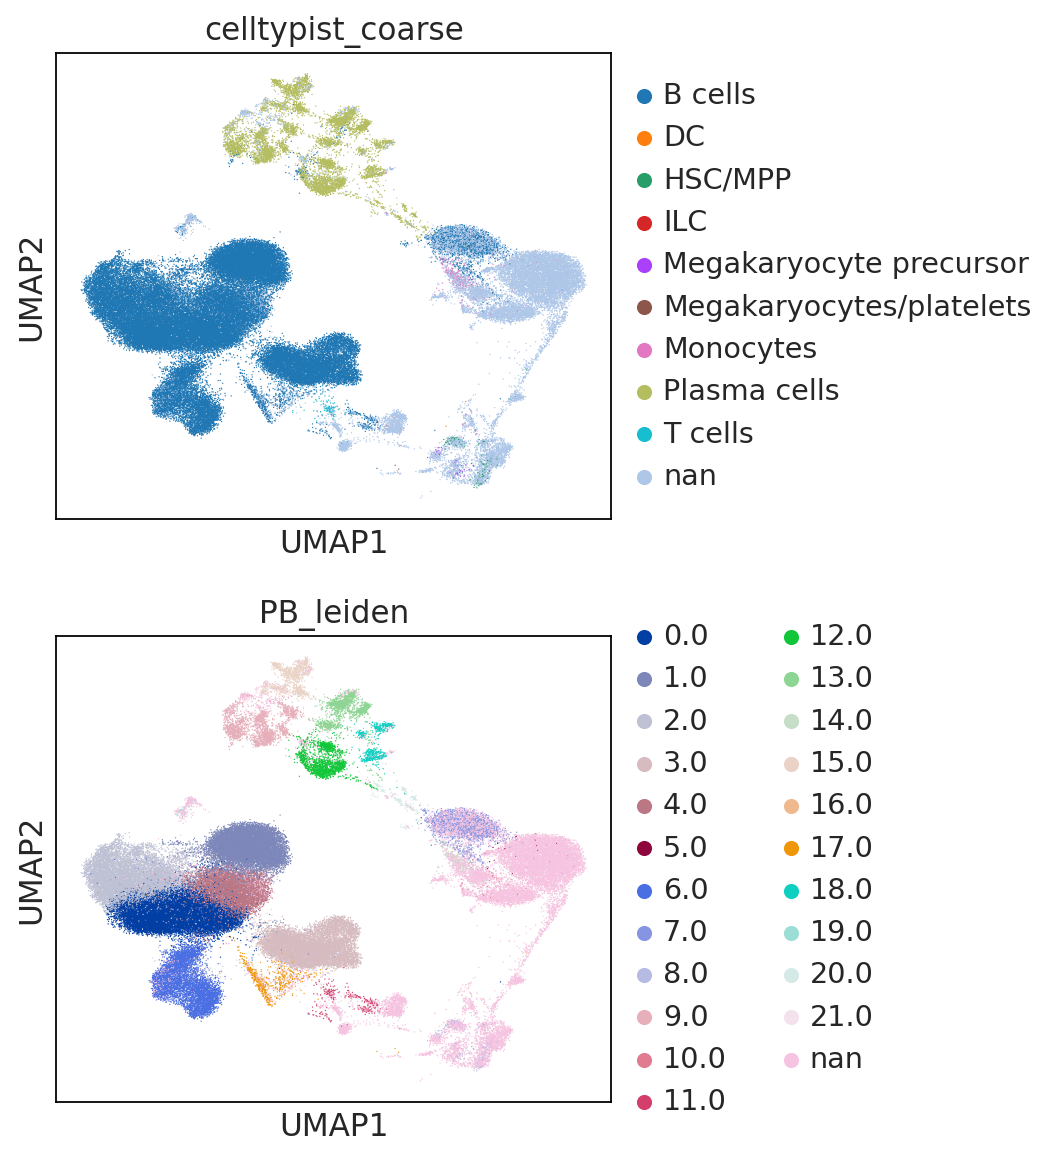

In [6]:
sc.pl.umap(adata, color = ['celltypist_coarse', "{}_leiden".format(tissue)], ncols=1)

## umis by celltype

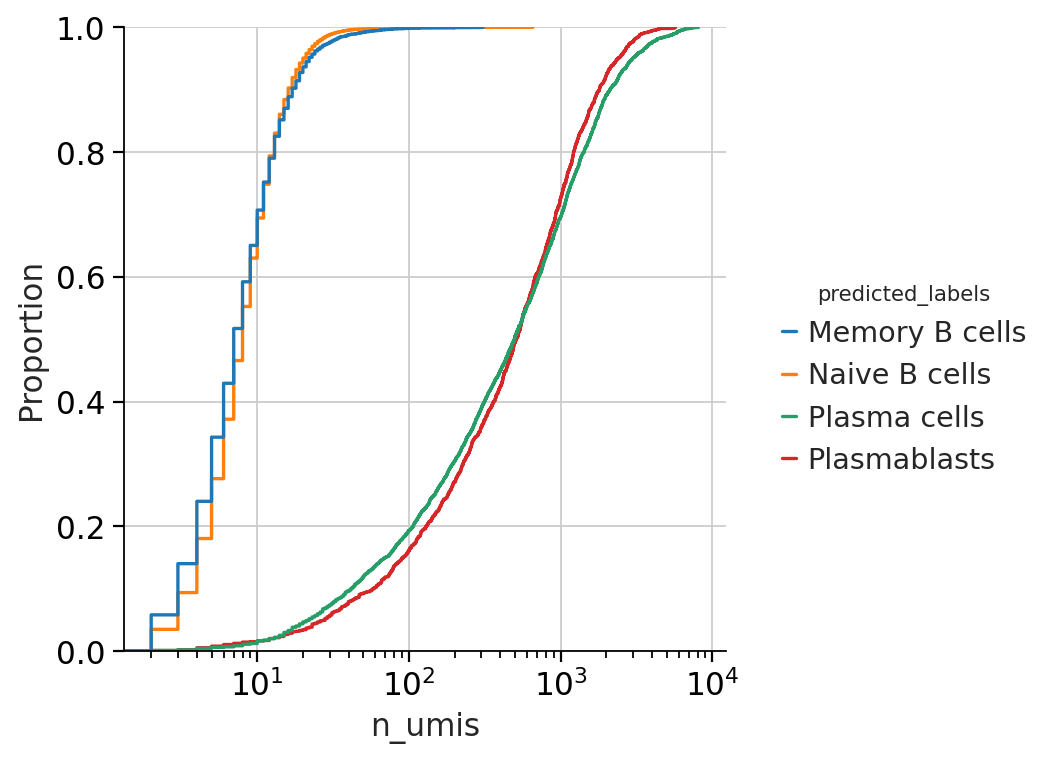

In [18]:
data = adata.obs[adata.obs.predicted_labels.str.contains("Naive B|Memory|Plasma")]
data.predicted_labels.cat.remove_unused_categories(inplace = True)
hue = 'predicted_labels'
kind = 'ecdf'
x = "n_umis"
g = sns.displot(data = data, x = x, kind = kind, log_scale=True, hue = hue)
save_figure(g.fig, "{}_n_umis_{}".format(x,kind,hue))

## Analyze ig gene expression for understanding ambient effects

In [20]:
# Is the total counts coming from IgH locus related to detection in the amplicon sequencing
umis = adata.to_df(layer = 'umi_counts')

In [21]:
ig_genes = list(adata.var.index[adata.var.index.str.contains('IGH|IGKC|IGLC')])

In [22]:
# igh genes
adata.obs['gex_igh_umis'] = umis[igh_genes].sum(axis = 1)
# ig genes
adata.obs['ig_genes'] = umis[ig_genes].sum(axis = 1)

In [23]:
sc.set_figure_params(color_map='mako')

In [25]:
adata.obs['ig_gene_contam'] = adata.obs.ig_genes > 0

In [26]:
adata.obs['ig_gene_contam']

cb_suid
AAACCTGAGAACTGTA_TBd3_fresh_P50     True
AAACCTGAGACAGACC_TBd3_fresh_P50     True
AAACCTGAGCACAGGT_TBd3_fresh_P50     True
AAACCTGAGCCACCTG_TBd3_fresh_P50     True
AAACCTGAGCCTTGAT_TBd3_fresh_P50     True
                                    ... 
TTTGTCATCATTCACT_TBd6_fresh_PBMC    True
TTTGTCATCCGCAAGC_TBd6_fresh_PBMC    True
TTTGTCATCCGCATCT_TBd6_fresh_PBMC    True
TTTGTCATCGTTACGA_TBd6_fresh_PBMC    True
TTTGTCATCTTCTGGC_TBd6_fresh_PBMC    True
Name: ig_gene_contam, Length: 86311, dtype: bool

"\nfor p in g.ax.patches:\n    txt = str(p.get_height().round(2)) + '%'\n    txt_x = p.get_x() \n    txt_y = p.get_height()\n    g.ax.text(txt_x,txt_y,txt)\n"

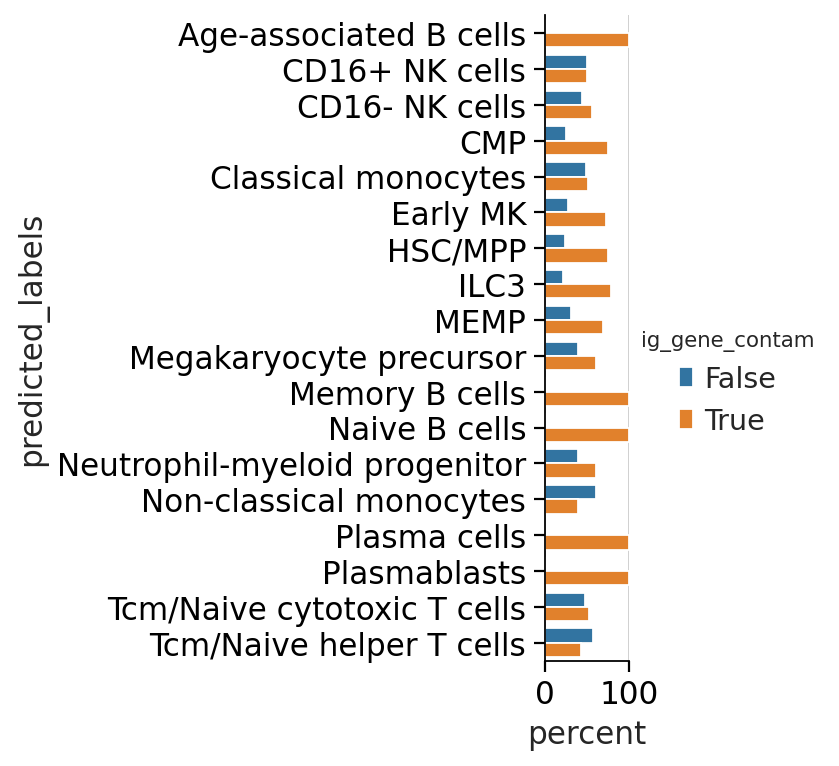

In [27]:
df = adata.obs
x,y = 'predicted_labels', 'ig_gene_contam'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(y=x,x='percent',hue=y,kind='bar',data=df1)
g.ax.set_xlim(0,100)

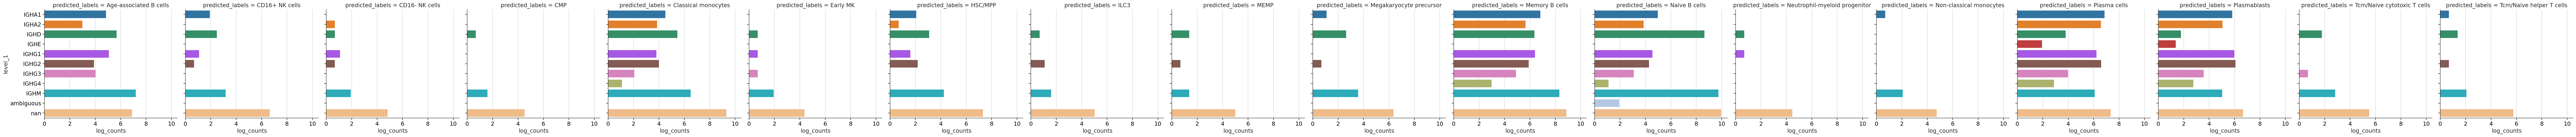

In [28]:
df = adata.obs
x,y = 'predicted_labels', 'c_call'

df1 = df.groupby(x)[y].value_counts(normalize=False)
#df1 = df1.mul(100)
df1 = df1.rename('counts').reset_index()
df1['log_counts'] = np.log(df1['counts'] + 1)
g = sns.catplot(y='level_1',x='log_counts',kind='bar',data=df1, col = x)
#g.ax.set_xlim(0,100)

In [29]:
# for each single cell where constant region reads are greater than 2 plot the level of agreement of constant region reads
adata.obs['igh_concordance'] = umis[igh_genes].max(axis = 1) / umis[igh_genes].sum(axis=1)

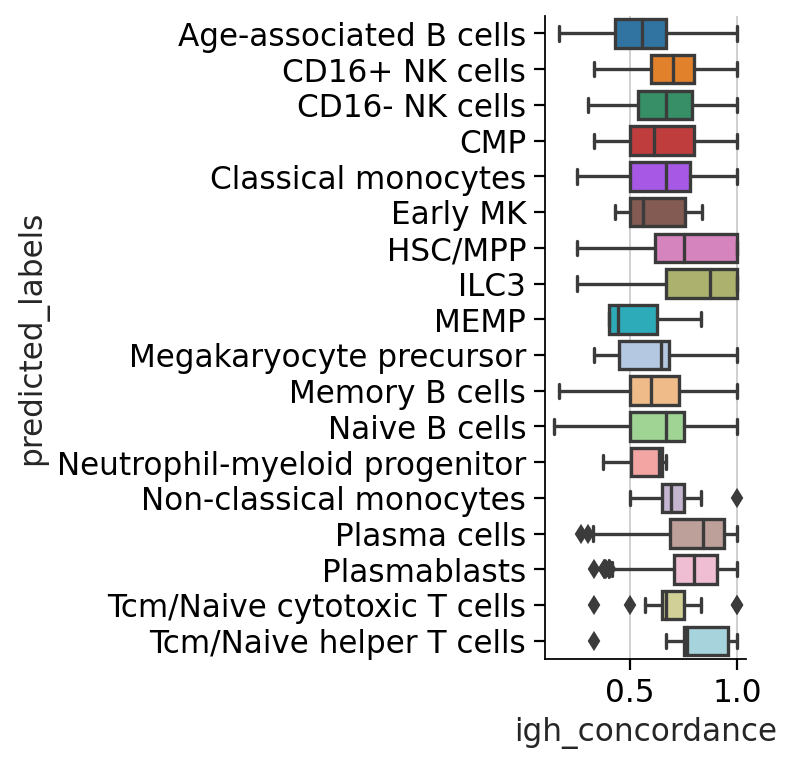

In [30]:
df = adata.obs
df = df[df.loc[:, 'gex_igh_umis'] > 2]
sns.catplot(data = df, x = 'igh_concordance', y = 'predicted_labels', kind='box')

In [ ]:
df = adata.obs
df = df[df.loc[:, 'gex_igh_umis'] > 2]
sns.catplot(data = df, x = 'igh_concordance', y = '', kind='box')

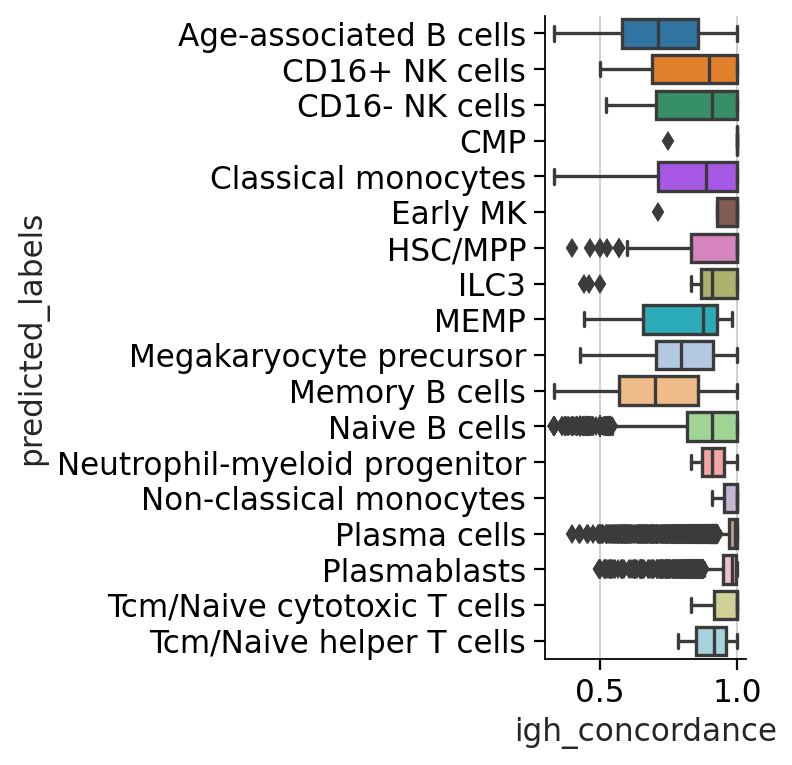

In [39]:
selector = adata.obs.index[adata.obs['gex_igh_umis'] > 2]
umis = umis[igh_genes]
umis.loc[:,'IGHA'] = umis['IGHA1'] + umis['IGHA2']
umis.loc[:,'IGHMD'] = umis['IGHM'] + umis['IGHD']
umis.loc[:,'IGHG'] = umis['IGHG1'] + umis['IGHG3'] + umis['IGHG4'] + umis['IGHG2']
_umis = umis.iloc[:,-3:]
# for each single cell where constant region reads are greater than 2 plot the level of agreement of constant region reads
adata.obs['igh_concordance'] = _umis.max(axis = 1) / _umis.sum(axis=1)
df = adata.obs
df = df[df.loc[:, 'gex_igh_umis'] > 5]
sns.catplot(data = df, x = 'igh_concordance', y = 'predicted_labels', kind='box')

In [ ]:
_umis / _umis.sum(axis = 1)

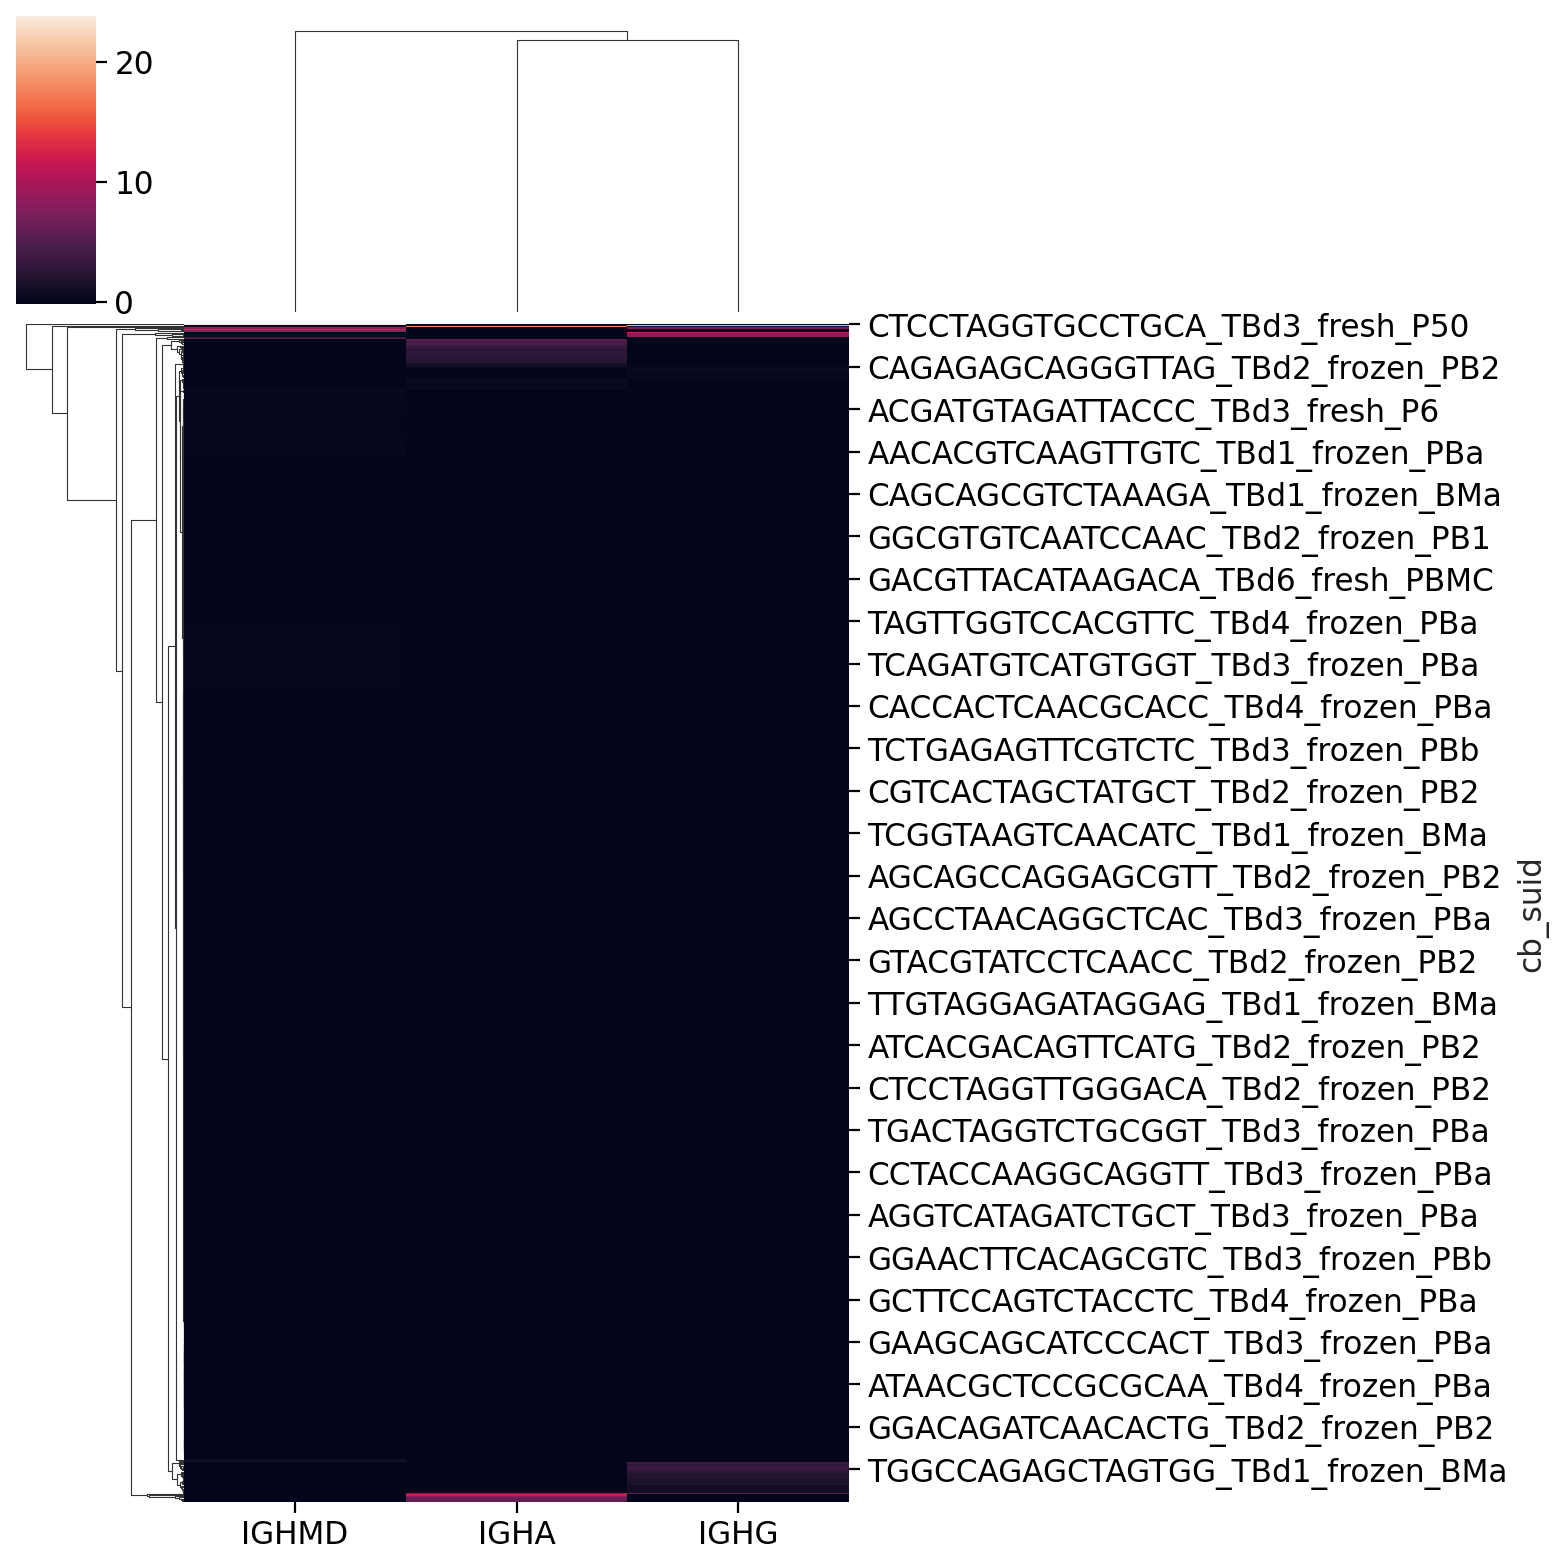

In [40]:
sns.clustermap(_umis.sample(n=1000), z_score=True)